# 2D segmentation using deep learning model

In this notebook, we will look the how to preprocess the 3D heart dataset into 2D png images and then we will use deep learning models for segmentation of 2D images. There are various steps used for segmentation using deep learning

### step1: Get dataset from website
### Step2: Split dataset into training and validation 
### Step3: Convert dataset from 3D volume(normally sorted in nifit format) into 2D png images
### Step4: prepare dataset and dataloader class
### Step5: Build 2D segmentation model
### Step6: Train 2D segmentation model
### Step7: Test 2D segmentation model
In this tutorial we will excute all steps one by one using  MM2 heart dataset

### Step2 Split dataset into training and validation folder

In [4]:
import os
import splitfolders
input_folder='heart_dataset\\datasets\\MandM2_dataset\\dataset'
output='heart_dataset\\datasets\\MandM2_dataset\\train_test_dataset'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output,seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 1404 files [00:06, 209.10 files/s]


### Step 3 convert 3D dataset into 2D png images and resize in same size

In [5]:
#%% convert 3D volume to 2D images after cropping and resized
#%dataset conversion from 3D to 2D segmentation
################################preprocessing and resizing function#######################################################

import numpy as np
import SimpleITK as sitk
from skimage.measure import regionprops
from glob import glob
import os

def ResampleXYZAxis(imImage, space=(1., 1., 1.), interp=sitk.sitkLinear):
    identity1 = sitk.Transform(3, sitk.sitkIdentity)
    sp1 = imImage.GetSpacing()
    sz1 = imImage.GetSize()

    sz2 = (int(round(sz1[0]*sp1[0]*1.0/space[0])), int(round(sz1[1]*sp1[1]*1.0/space[1])), int(round(sz1[2]*sp1[2]*1.0/space[2])))

    imRefImage = sitk.Image(sz2, imImage.GetPixelIDValue())
    imRefImage.SetSpacing(space)
    imRefImage.SetOrigin(imImage.GetOrigin())
    imRefImage.SetDirection(imImage.GetDirection())

    imOutImage = sitk.Resample(imImage, imRefImage, identity1, interp)

    return imOutImage

def ResampleLabelToRef(imLabel, imRef, interp=sitk.sitkNearestNeighbor):
    identity1 = sitk.Transform(3, sitk.sitkIdentity)

    imRefImage = sitk.Image(imRef.GetSize(), imLabel.GetPixelIDValue())
    imRefImage.SetSpacing(imRef.GetSpacing())
    imRefImage.SetOrigin(imRef.GetOrigin())
    imRefImage.SetDirection(imRef.GetDirection())
        
    ResampledLabel = sitk.Resample(imLabel, imRefImage, identity1, interp)
    
    return ResampledLabel



def ITKReDirection(itkimg, target_direction=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)):
    # target direction should be orthognal, i.e. (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

    # permute axis
    tmp_target_direction = np.abs(np.round(np.array(target_direction))).reshape(3,3).T
    current_direction = np.abs(np.round(itkimg.GetDirection())).reshape(3,3).T
    
    permute_order = []
    if not np.array_equal(tmp_target_direction, current_direction):
        for i in range(3):
            for j in range(3):
                if np.array_equal(tmp_target_direction[i], current_direction[j]):
                    permute_order.append(j)
                    #print(i, j)
                    #print(permute_order)
                    break
        redirect_img = sitk.PermuteAxes(itkimg, permute_order)
    else:
        redirect_img = itkimg
    # flip axis
    current_direction = np.round(np.array(redirect_img.GetDirection())).reshape(3,3).T
    current_direction = np.max(current_direction, axis=1)

    tmp_target_direction = np.array(target_direction).reshape(3,3).T 
    tmp_target_direction = np.max(tmp_target_direction, axis=1)
    flip_order = ((tmp_target_direction * current_direction) != 1)
    fliped_img = sitk.Flip(redirect_img, [bool(flip_order[0]), bool(flip_order[1]), bool(flip_order[2])])
    return fliped_img


def CropForeground(imImage, imLabel, context_size=[10, 30, 30]):
    # the context_size is in numpy indice order: z, y, x
    # Note that SimpleITK use the indice order of: x, y, z
    
    npImg = sitk.GetArrayFromImage(imImage)
    npLab = sitk.GetArrayFromImage(imLabel)

    mask = (npLab>0).astype(np.uint8) # foreground mask
    
    regions = regionprops(mask)
    assert len(regions) == 1

    zz, yy, xx = npImg.shape

    z, y, x = regions[0].centroid

    z_min, y_min, x_min, z_max, y_max, x_max = regions[0].bbox
    print('forground size:', z_max-z_min, y_max-y_min, x_max-x_min)

    z, y, x = int(z), int(y), int(x)

    z_min = max(0, z_min-context_size[0])
    z_max = min(zz, z_max+context_size[0])
    y_min = max(0, y_min-context_size[2])
    y_max = min(yy, y_max+context_size[2])
    x_min = max(0, x_min-context_size[1])
    x_max = min(xx, x_max+context_size[1])

    img = npImg[z_min:z_max, y_min:y_max, x_min:x_max]
    lab = npLab[z_min:z_max, y_min:y_max, x_min:x_max]

    croppedImage = sitk.GetImageFromArray(img)
    croppedLabel = sitk.GetImageFromArray(lab)


    croppedImage.SetSpacing(imImage.GetSpacing())
    croppedLabel.SetSpacing(imImage.GetSpacing())
    
    croppedImage.SetDirection(imImage.GetDirection())
    croppedLabel.SetDirection(imImage.GetDirection())

    return croppedImage, croppedLabel

import numpy as np
import SimpleITK as sitk
#from utils import ResampleXYZAxis, ResampleLabelToRef, CropForeground
import os
import random
import yaml
import copy
import pdb

def ResampleImage(imImage,imLabel,target_spacing=(1., 1., 1.)):

    assert imImage.GetSpacing() == imLabel.GetSpacing()
    assert imImage.GetSize() == imLabel.GetSize()


    spacing = imImage.GetSpacing()
    origin = imImage.GetOrigin()


    npimg = sitk.GetArrayFromImage(imImage).astype(np.int32)
    nplab = sitk.GetArrayFromImage(imLabel).astype(np.uint8)
    z, y, x = npimg.shape

    imImage.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))
    imLabel.SetDirection((1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0))


    re_img_xy = ResampleXYZAxis(imImage, space=(target_spacing[0], target_spacing[1], spacing[2]), interp=sitk.sitkBSpline)
    re_lab_xy = ResampleLabelToRef(imLabel, re_img_xy, interp=sitk.sitkNearestNeighbor)

    re_img_xyz = ResampleXYZAxis(re_img_xy, space=(target_spacing[0], target_spacing[1], target_spacing[2]), interp=sitk.sitkNearestNeighbor)
    re_lab_xyz = ResampleLabelToRef(re_lab_xy, re_img_xyz, interp=sitk.sitkNearestNeighbor)
    

    cropped_img, cropped_lab = CropForeground(re_img_xyz, re_lab_xyz, context_size=[10, 15, 15])
    #print(cropped_img.GetSize())
    #print(cropped_lab.GetSize())
    return cropped_img,cropped_lab
 
def resize_mask(image,new_size):
    # Define image size
    original_size = image.GetSize()
    # Define the resampler
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing([sz * (orig / new) for sz, orig, new in zip(image.GetSpacing(), original_size, new_size)])
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)  # Nearest neighbor for segmentation masks
    # Perform the resampling
    resized_mask = resampler.Execute(image)
    return resized_mask

def resize_image(image,new_size):
    # Define image size
    original_size = image.GetSize()
    # Define the resampler
    resampler = sitk.ResampleImageFilter()
    resampler.SetOutputSpacing([sz * (orig / new) for sz, orig, new in zip(image.GetSpacing(), original_size, new_size)])
    resampler.SetSize(new_size)
    resampler.SetInterpolator(sitk.sitkLinear)  # Use linear interpolation for intensity images
    # Perform the resampling
    resized_image = resampler.Execute(image)
    return resized_image

C:\Users\aq22\Anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [6]:

#%% training dataset convert into images and masks

pathdata='heart_dataset\\datasets\\MandM2_dataset\\train_test_dataset\\train'
pathimg=glob(os.path.join(pathdata,'images','*.nii.gz'))
pathlabel=glob(os.path.join(pathdata,'labels','*.nii.gz'))

pathsaveim='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\train\\images'
pathsavelabel='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\train\\masks'

#from skimage.transform import io
import skimage.io as io
from skimage import io, color
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
for i in range(0,len(pathimg)):
    pathim=pathimg[i]
    pathma=pathlabel[i]
    img=sitk.ReadImage(pathim)
    #img_array=img.get_fdata()
    mask=sitk.ReadImage(pathma)
    ############# get interplation data#################################
    cropped_img,cropped_lab=ResampleImage(img, mask, (1.2333333202870196, 1.233333339535614, 9.599999505734397))
    #cropped_img,cropped_lab=ResampleImage1(img, mask, (1.4583333730697632, 1.4583333730697632, 3.0))
    resized_image=resize_image(cropped_img,(224,224,16))
    resized_mask=resize_mask(cropped_lab,(224,224,16))
    print(resized_image.GetSize())
    print(resized_mask.GetSize())
    img_array=sitk.GetArrayFromImage(resized_image)
    mask_array=sitk.GetArrayFromImage(resized_mask)
    patient_name=pathim.split('\\')[-1].split('.')[0]
    ### 16x224x224 3d volume
    for j in range(0,img_array.shape[0]):
        img=img_array[j,:,:] ####[0,16,:,:]
        img = (255 * (img - np.min(img)) / np.ptp(img)).astype(np.uint8)
        # Convert to uint8 (values in the range [0, 255])
        img= color.gray2rgb(img)
        img = img_as_ubyte(img)
        print(img.shape)
        #img= Image.fromarray(img, mode='F')
        msk=mask_array[j,:,:].astype(np.uint8)
        #msk= Image.fromarray(msk,mode='F')
        #print(img.shape)
        #plt.imshow(img)
        #plt.imshow(msk)
        print(np.unique(msk))
        #img.save(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'))
        #msk.save(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'))
        io.imsave(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'),img)
        io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
        
    #break

forground size: 9 76 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 64 55
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\001_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 79 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 61 58
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\002_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 89 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 70 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\003_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 76 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 63 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\004_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 81 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 72 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:49: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\images\005_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'),img)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\005_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 73 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
forground size: 9 63 59
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\006_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 77 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\007_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 69 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 61 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\008_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 97 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\009_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 76 56
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\010_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\010_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\010_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\010_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\010_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\010_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\010_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\010_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\010_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 85 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 7 71 56
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\011_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 101 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 89 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\012_saes_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 10 83 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\013_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\013_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\013_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\013_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\013_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\013_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\013_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\013_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 94 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 78 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\014_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 81 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 66 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:49: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\images\015_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'),img)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\015_saes_15.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 72 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\016_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 78 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 7 62 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\017_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 90 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 6 72 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\018_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 92 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 79 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\019_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 79 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 65 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\020_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 67 59
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\021_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\021_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\021_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\021_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\021_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\021_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\021_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\021_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\021_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 81 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\022_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 73 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\023_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\023_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\023_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\023_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\023_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\023_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\023_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\023_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 80 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\024_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\024_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\024_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\024_saes_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\024_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\024_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\024_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\024_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\024_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 82 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 71 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\025_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 78 94
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\026_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 90 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 71 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\027_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 72 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\029_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 7 78 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 6 63 54
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\030_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 6 63 43
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\031_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 86 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saed_15.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2]
forground size: 6 61 55
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\032_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 86 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 71 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\033_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 79 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\034_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\034_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\034_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\034_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\034_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\034_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\034_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\034_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
forground size: 6 62 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\035_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 7 71 57
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\036_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 68 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\037_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 94 97
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 79 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\038_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
forground size: 10 88 101
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 75 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\039_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 88 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_9.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 71 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\040_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 98 95
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\041_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\041_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\041_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\041_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\041_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\041_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\041_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\041_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
forground size: 10 99 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 93 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\042_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 97 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 82 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\043_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
forground size: 10 119 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 97 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\044_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 12 112 121
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 12 112 116
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\045_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
forground size: 10 98 95
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 92 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\046_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 85 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 73 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\047_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 84 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 69 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\049_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 87 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 70 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\050_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
forground size: 10 92 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saed_10.png is a low contrast image
  io.imsave(os.path.joi

forground size: 9 78 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\051_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 11 97 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
forground size: 10 87 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\052_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 84 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 74 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\053_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 103 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 91 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\054_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 100 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\055_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 102 96
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
forground size: 9 89 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\056_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
forground size: 10 101 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\057_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 98 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 91 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\058_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 101 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 88 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\059_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 91 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 79 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\060_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 10 103 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 91 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_6.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\061_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 96 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\062_saed_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 11 97 99
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 90 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\063_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 88 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 10 84 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\064_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 11 92 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 86 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\065_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 109 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 98 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\066_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 110 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 98 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\067_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 91 97
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\068_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 103 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 93 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\069_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 12 109 109
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
forground size: 11 96 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\070_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 95 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\071_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 101 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 8 84 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\072_saes_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 9 87 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
forground size: 8 80 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\073_saes_15.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
forground size: 9 81 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
forground size: 8 71 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\074_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 87 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 74 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\075_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 90 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 8 78 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\076_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 94 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 79 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\077_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 103 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\078_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 93 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 78 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\079_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 84 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 67 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\080_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 96 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\081_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 79 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saed_15.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]
forground size: 8 68 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\082_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 99 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saed_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
forground size: 9 91 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_6.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\084_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 11 101 94
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saed_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
forground size: 8 82 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\085_saes_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 10 95 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\086_saed_15.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 10 98 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 84 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\087_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
forground size: 10 88 94
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saed_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]
forground size: 8 78 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\088_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 91 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 75 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\090_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]
forground size: 10 89 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 73 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\091_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 83 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 6 69 59
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\092_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 81 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 6 72 62
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\093_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 103 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\094_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 10 98 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 78 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\095_saes_15.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]
forground size: 10 97 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\096_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 10 88 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
forground size: 8 78 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\097_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 90 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 77 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\098_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 85 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saed_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
forground size: 7 67 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\099_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
forground size: 7 73 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\100_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 11 101 99
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\101_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 93 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\102_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 92 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saed_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 8 87 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\103_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 107 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\104_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 95 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
forground size: 8 76 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\105_saes_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 8 94 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\106_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 86 99
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 76 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\107_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 94 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\108_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 93 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saed_15.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 8 81 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\109_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 83 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 63 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\110_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 6 64 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\111_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 92 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 83 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\112_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 83 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 68 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\113_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 87 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 76 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\114_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 71 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\115_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 77 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 72 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\116_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 87 66
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 69 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\117_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 94 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 86 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\118_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 10 98 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_6.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\119_saes_15.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 9 100 96
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
forground size: 9 90 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\120_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 86 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 80 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\121_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 75 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 68 58
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\122_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 100 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saed_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 8 92 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\123_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 100 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 95 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\125_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 88 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 81 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\126_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 92 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 83 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\127_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 97 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 86 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\129_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 74 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\130_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 89 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0 1 2]
forground size: 7 80 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\131_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 94 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 87 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_4.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\132_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 84 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 6 76 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\134_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 10 89 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\135_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\135_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\135_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\135_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\135_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\135_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\135_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\135_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\135_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 106 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 99 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\136_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 90 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 81 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\137_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 10 92 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\140_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\140_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\140_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\140_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\140_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\140_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\140_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\140_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 82 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 65 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\141_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 96 99
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 84 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\142_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 75 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 63 63
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\143_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 99 98
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
forground size: 8 83 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\144_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 89 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 89 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\145_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 82 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 64 66
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\146_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 105 101
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 87 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\147_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 88 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 83 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\148_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 83 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\149_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\149_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\149_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\149_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 7 70 62
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\149_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\149_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\149_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\149_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 111 94
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\150_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\150_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\150_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\150_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\150_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\150_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\150_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\150_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 74 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 6 63 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\151_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 66 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\152_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\152_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\152_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\152_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\152_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\152_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\152_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\152_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 10 98 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 83 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\153_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 102 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_7.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
forground size: 6 82 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_8.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\154_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 89 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_9.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 6 81 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\155_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 90 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 80 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\156_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
forground size: 9 85 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 83 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\157_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 104 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saed_4.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 6 82 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\158_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 90 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:49: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\images\159_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'),img)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 77 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
forground size: 7 77 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:49: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\images\159_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'),img)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\159_saes_15.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saed_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saed_6.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:49: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\images\160_saed_15.png is a low contrast image
  io.imsave(os.path

forground size: 7 69 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\160_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 73 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 6 66 54
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\161_saes_9.png is a low contrast image
  io.imsave(os.path.join

forground size: 10 87 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 72 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\163_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 58 54
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\164_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\164_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\164_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\164_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
forground size: 6 81 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\165_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\165_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\165_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\165_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\165_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\165_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\165_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\165_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 79 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\165_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saed_4.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 69 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\167_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 92 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 75 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\168_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 7 75 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\171_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 81 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 2]
forground size: 7 66 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\172_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 78 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
forground size: 7 62 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\173_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 88 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 6 70 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\174_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 89 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 7 69 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\175_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 11 95 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 10 76 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\176_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 89 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saed_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 83 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\178_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 82 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 76 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\179_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
forground size: 9 114 99
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 99 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\180_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 104 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 99 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\181_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 93 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 7 87 73


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\182_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
forground size: 9 83 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 66 55
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\183_saes_10.png is a low contrast image
  io.imsave(os.path.joi

forground size: 9 81 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\184_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\184_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\184_saed_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\184_saed_5.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\184_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\184_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\184_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\184_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
forground size: 8 82 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 60 54
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\186_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 88 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 6 71 66
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saes_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\188_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 82 97
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 74 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\189_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 83 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 71 59
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\190_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 85 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\191_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\191_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\191_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\191_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\191_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\191_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\191_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\191_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 81 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 72 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\192_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 103 99
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\193_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\193_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\193_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\193_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\193_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\193_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\193_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\193_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 83 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\194_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\194_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\194_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\194_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\194_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\194_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\194_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\194_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 10 92 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 3)
[0]
forground size: 9 80 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\195_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 86 62
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 71 54
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\196_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 103 100
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 84 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\197_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 110 94
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 98 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\198_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 10 89 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 73 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\199_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 95 97
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
forground size: 8 82 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\200_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 83 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\201_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\201_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\201_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\201_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\201_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\201_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\201_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\201_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 10 96 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 79 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\202_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 69 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\203_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\203_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\203_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\203_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\203_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\203_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\203_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\203_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 101 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 7 82 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\204_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 73 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 59 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\205_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 10 93 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 78 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\206_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 74 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\208_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\208_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\208_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\208_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\208_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\208_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\208_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\208_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 80 106
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 72 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\209_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 10 87 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 75 63
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\210_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 6 62 48
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\211_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\211_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\211_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\211_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\211_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\211_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\211_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\211_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 98 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 89 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\212_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 84 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\213_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\213_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\213_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\213_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\213_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\213_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\213_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\213_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 82 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 66 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\214_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 85 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\215_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\215_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\215_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\215_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\215_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\215_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\215_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\215_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 79 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 71 63
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\216_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 91 95
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 77 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\217_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 92 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
forground size: 10 78 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\218_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
forground size: 10 94 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 85 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\219_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 10 92 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\220_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\220_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\220_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\220_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 79 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 66 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\221_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 10 67 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 56 63
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\222_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 84 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 71 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\223_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 97 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\224_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\224_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\224_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\224_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\224_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\224_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\224_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\224_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 93 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\225_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\225_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\225_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\225_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\225_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\225_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\225_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\225_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 10 97 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\226_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\226_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\226_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\226_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\226_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\226_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\226_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\226_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 76 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\227_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\227_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\227_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\227_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\227_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\227_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\227_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\227_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 68 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\228_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\228_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\228_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\228_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 93 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saed_10.png is a low contrast image
  io.imsave(os.path.joi

forground size: 8 83 66
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\229_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 94 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\230_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\230_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\230_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\230_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\230_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\230_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\230_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\230_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 113 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 107 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\231_saes_10.png is a low contrast image
  io.imsave(os.path.joi

forground size: 8 96 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\232_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\232_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\232_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\232_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\232_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\232_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\232_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\232_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 84 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saed_10.png is a low contrast image
  io.imsave(os.path.joi

forground size: 8 74 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\233_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 85 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\234_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\234_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\234_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\234_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 78 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\234_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\234_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\234_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\234_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 105 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
forground size: 10 108 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\235_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 88 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 73 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\236_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 94 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 78 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\237_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 10 94 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\238_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\238_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\238_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\238_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\238_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\238_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\238_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\238_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 93 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 86 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\239_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 11 110 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\240_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\240_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\240_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\240_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\240_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\240_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\240_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\240_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 10 95 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\241_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\241_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\241_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\241_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\241_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\241_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\241_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\241_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 10 96 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\242_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\242_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\242_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\242_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\242_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\242_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\242_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\242_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 82 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\243_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\243_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\243_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\243_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 7 80 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 6 67 62
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\244_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 11 107 97
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
forground size: 11 97 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\245_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
forground size: 8 98 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saed_13.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 82 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\246_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 89 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\247_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\247_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\247_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\247_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\247_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\247_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\247_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\247_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 92 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
forground size: 7 82 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\248_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 99 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 88 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\249_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 10 95 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 85 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\250_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 11 91 98
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 77 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\251_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 10 93 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 81 66
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\252_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 11 107 101
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 11 96 97
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\253_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 85 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\254_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\254_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\254_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\254_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\254_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\254_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\254_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\254_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 90 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 81 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\255_saes_10.png is a low contrast image
  io.imsave(os.path.joi

forground size: 10 86 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\256_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\256_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\256_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\256_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\256_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\256_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\256_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\256_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 92 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\257_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\257_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\257_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\257_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 73 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\257_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\257_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\257_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\257_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 88 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 6 69 63
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\258_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 10 106 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 82 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\259_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 6 63 63
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\260_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\260_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\260_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\260_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\260_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\260_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\260_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\260_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 74 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 60 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saes_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\261_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 105 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 85 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\262_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 83 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saed_10.png is a low contrast image
  io.imsave(os.path.joi

forground size: 7 63 57
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\264_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 79 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 70 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\265_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 103 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\266_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\266_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\266_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\266_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\266_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\266_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\266_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\266_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 90 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
forground size: 7 72 62
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\267_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 86 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 69 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\269_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
forground size: 9 80 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 65 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\270_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 11 98 95
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\271_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\271_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\271_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\271_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 78 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\271_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\271_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\271_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\271_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 88 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 7 73 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\272_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 90 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 76 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\273_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 86 96
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saed_10.png is a low contrast image
  io.imsave(os.path.joi

forground size: 8 73 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\274_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 97 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 83 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\275_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 73 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\276_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\276_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\276_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\276_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\276_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\276_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\276_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\276_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 96 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 80 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\277_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 105 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\279_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\279_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\279_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\279_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\279_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\279_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\279_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\279_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\279_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 96 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 83 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\280_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 74 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 61 62
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\281_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 62 61
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\282_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 11 85 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
forground size: 9 74 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\283_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 10 118 100
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 10 122 96
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\284_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 87 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\286_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\286_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\286_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\286_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\286_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\286_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\286_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\286_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
forground size: 9 106 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 85 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\287_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 100 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\288_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\288_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\288_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\288_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\288_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\288_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\288_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\288_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 83 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\289_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\289_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\289_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\289_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]
forground size: 7 96 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\290_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\290_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\290_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\290_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\290_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\290_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\290_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\290_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 88 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 74 66
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\291_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 82 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\293_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\293_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\293_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\293_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 73 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\294_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\294_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\294_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\294_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\294_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\294_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\294_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\294_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 114 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 100 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\295_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 114 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saed_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 97 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\296_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 95 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 82 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\297_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 105 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 94 63
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\298_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 105 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 91 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\299_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 83 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\300_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\300_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\300_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\300_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\300_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\300_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\300_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\300_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 81 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saed_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 67 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\302_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 5 60 59
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
forground size: 5 54 47
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\303_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 12 85 100
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\304_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\304_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\304_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\304_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0]
forground size: 10 96 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 83 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\305_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 100 100
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 87 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\306_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 86 104
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\307_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\307_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\307_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\307_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\307_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\307_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\307_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\307_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 9 91 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\308_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\308_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\308_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\308_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\308_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\308_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\308_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\308_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 95 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 84 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\309_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
forground size: 9 81 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 66 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saes_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\310_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 11 107 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\311_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\311_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\311_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\311_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 99 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\311_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\311_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\311_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\311_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 91 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\312_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\312_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\312_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\312_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 93 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\313_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\313_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\313_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\313_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 83 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 73 63
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\314_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 11 105 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
forground size: 10 100 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\315_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 11 109 104
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 103 98
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\316_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 107 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\317_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\317_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\317_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\317_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\317_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\317_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\317_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\317_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 92 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\318_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\318_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\318_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\318_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\318_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\318_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\318_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\318_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 100 98
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 8 88 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\319_saes_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 11 97 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 77 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\320_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 88 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\321_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\321_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\321_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\321_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\321_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\321_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\321_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\321_saed_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 9 68 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\322_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\322_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\322_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\322_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\322_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\322_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\322_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\322_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 10 100 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\323_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\323_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\323_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\323_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\323_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\323_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\323_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\323_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 87 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
forground size: 8 73 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\324_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 74 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\326_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\326_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\326_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\326_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\326_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\326_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\326_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\326_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 86 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 73 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\327_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 78 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 67 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\328_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 77 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\329_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\329_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\329_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\329_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\329_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\329_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\329_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\329_saes_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 97 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 85 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\331_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 95 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\332_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\332_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\332_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\332_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\332_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\332_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\332_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\332_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 11 85 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saed_15.png is a low contrast image
  io.imsave(os.path.

forground size: 9 72 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\333_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 89 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\334_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\334_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\334_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\334_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 11 88 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\336_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\336_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\336_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\336_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\336_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\336_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\336_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\336_saed_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
forground size: 10 94 97
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\337_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\337_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\337_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\337_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
forground size: 9 82 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\337_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\337_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\337_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\337_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
forground size: 9 84 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 8 68 58
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\338_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
forground size: 10 84 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\339_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\339_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\339_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\339_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\339_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\339_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\339_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\339_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 7 79 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 6 62 62
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\340_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 79 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\341_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\341_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\341_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\341_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\341_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\341_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\341_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\341_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 92 98
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 9 86 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\342_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
forground size: 12 96 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 11 85 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\343_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 89 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\344_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\344_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\344_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\344_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\344_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\344_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\344_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\344_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 8 99 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 7 83 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\345_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 76 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\346_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\346_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\346_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\346_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\346_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\346_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\346_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\346_saes_10.png is a low contrast image
  io.imsave(os.path.joi

forground size: 8 102 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\347_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\347_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\347_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\347_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 111 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saed_14.png is a low contrast image
  io.imsave(os.path.

forground size: 10 97 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\348_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 7 86 95
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\349_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\349_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\349_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\349_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\349_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\349_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\349_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\349_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 8 101 99
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saed_12.png is a low contrast image
  io.imsave(os.path.j

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 7 96 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_3.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\350_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 91 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 76 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\351_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 78 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\352_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\352_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\352_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\352_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\352_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\352_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\352_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\352_saes_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 7 81 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saed_11.png is a low contrast image
  io.imsave(os.path.jo

forground size: 6 70 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:49: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\images\353_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'),img)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\353_saes_15.png is a low contrast image
  io.imsave(os.path.jo

forground size: 9 102 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 93 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_11.png is a low contrast image
  io.imsave(os.path.jo

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\354_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 7 73 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_9.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 7 68 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_5.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_8.png is a low contrast image
  io.imsave(os.path.join

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\355_saes_14.png is a low contrast image
  io.imsave(os.path.

(224, 224, 3)
[0]
forground size: 7 90 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_10.png is a low contrast image
  io.imsave(os.path.joi

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\356_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 92 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saed_13.png is a low contrast image
  io.imsave(os.path.

forground size: 7 84 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\357_saes_12.png is a low contrast image
  io.imsave(os.path.j

forground size: 7 95 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
forground size: 5 82 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\358_saes_13.png is a low contrast image
  io.imsave(os.path.

forground size: 10 92 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\359_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\359_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\359_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\359_saes_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\359_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\359_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\359_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\359_saes_15.png is a low contrast image
  io.imsave(os.path.

forground size: 8 79 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\360_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\360_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\360_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\360_saed_3.png is a low contrast image
  io.imsave(os.path.join

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\360_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\360_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\360_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\3150817691.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\train\masks\360_saed_10.png is a low contrast image
  io.imsave(os.path.joi

In [7]:
#%% val dataset convert into images and masks

pathdata='heart_dataset\\datasets\\MandM2_dataset\\train_test_dataset\\val'
pathimg=glob(os.path.join(pathdata,'images','*.nii.gz'))
pathlabel=glob(os.path.join(pathdata,'labels','*.nii.gz'))

pathsaveim='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\val\\images'
pathsavelabel='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\val\\masks'

#from skimage.transform import io
import skimage.io as io
from skimage import io, color
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
for i in range(0,len(pathimg)):
    pathim=pathimg[i]
    pathma=pathlabel[i]
    img=sitk.ReadImage(pathim)
    #img_array=img.get_fdata()
    mask=sitk.ReadImage(pathma)
    ############# get interplation data#################################
    cropped_img,cropped_lab=ResampleImage(img, mask, (1.2333333202870196, 1.233333339535614, 9.599999505734397))
    #cropped_img,cropped_lab=ResampleImage1(img, mask, (1.4583333730697632, 1.4583333730697632, 3.0))
    resized_image=resize_image(cropped_img,(224,224,16))
    resized_mask=resize_mask(cropped_lab,(224,224,16))
    print(resized_image.GetSize())
    print(resized_mask.GetSize())
    img_array=sitk.GetArrayFromImage(resized_image)
    mask_array=sitk.GetArrayFromImage(resized_mask)
    patient_name=pathim.split('\\')[-1].split('.')[0]
    ### 16x224x224 3d volume
    for j in range(0,img_array.shape[0]):
        img=img_array[j,:,:] ####[0,16,:,:]
        img = (255 * (img - np.min(img)) / np.ptp(img)).astype(np.uint8)
        # Convert to uint8 (values in the range [0, 255])
        img= color.gray2rgb(img)
        img = img_as_ubyte(img)
        print(img.shape)
        #img= Image.fromarray(img, mode='F')
        msk=mask_array[j,:,:].astype(np.uint8)
        #msk= Image.fromarray(msk,mode='F')
        #print(img.shape)
        #plt.imshow(img)
        #plt.imshow(msk)
        print(np.unique(msk))
        #img.save(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'))
        #msk.save(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'))
        io.imsave(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'),img)
        io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
        
    #break

forground size: 8 81 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\007_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\007_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\007_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\007_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\007_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\007_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\007_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\007_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 7 82 62
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\009_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\009_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\009_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\009_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 80 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\010_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\010_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\010_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\010_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 70 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\013_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\013_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\013_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\013_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\013_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\013_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\013_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\013_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 82 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\016_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\016_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\016_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\016_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\016_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\016_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\016_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\016_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 87 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\021_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\021_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\021_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\021_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\021_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\021_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\021_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\021_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 6 65 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\022_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\022_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\022_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\022_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\022_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\022_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\022_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\022_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\022_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 89 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\023_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\023_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\023_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\023_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\023_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\023_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\023_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\023_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 90 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\024_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\024_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\024_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\024_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\024_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\024_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\024_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\024_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 6 62 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\026_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\026_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\026_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\026_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
forground size: 7 79 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 6 62 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\028_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 6 60 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\029_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\029_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\029_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\029_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\029_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\029_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\029_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\029_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

(224, 224, 3)
[0]
forground size: 7 82 55
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\031_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\031_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\031_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\031_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\031_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\031_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\031_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\031_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 83 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\034_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\034_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\034_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\034_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\034_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\034_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\034_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\034_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 78 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\035_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\035_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\035_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\035_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\035_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\035_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\035_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\035_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 86 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\036_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\036_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\036_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\036_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\036_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\036_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\036_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\036_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 6 54 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\037_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\037_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\037_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\037_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\037_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\037_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\037_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\037_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0]
forground size: 10 106 97
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\041_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\041_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\041_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\041_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\041_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\041_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\041_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\041_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 100 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\041_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\055_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\055_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\055_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavela

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\055_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\055_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\055_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\055_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
forground size: 8 83 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\057_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\057_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\057_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\057_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\057_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\057_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\057_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\057_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 94 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\062_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\062_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\062_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\062_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\062_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\062_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\062_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\062_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 9 87 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\068_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\068_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\068_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\068_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\068_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\068_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\068_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\068_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 7 79 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\071_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\071_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\071_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\071_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\071_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\071_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\071_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\071_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 8 88 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\078_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\078_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\078_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\078_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\078_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\078_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\078_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\078_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 8 79 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\081_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\081_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\081_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\081_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\081_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\081_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\081_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\081_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 91 96
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\083_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\083_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\083_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\083_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 7 79 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\083_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\083_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\083_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\083_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 78 62
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\086_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\086_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\086_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\086_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\086_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\086_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\086_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\086_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 9 89 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0]
forground size: 8 77 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\089_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 9 88 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\094_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\094_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\094_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\094_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\094_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\094_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\094_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\094_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 87 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\096_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\096_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\096_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\096_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\096_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\096_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\096_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\096_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 87 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\100_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\100_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\100_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\100_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 11 98 94
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\101_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\101_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\101_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\101_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\101_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\101_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\101_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\101_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0]
forground size: 8 82 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\102_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\102_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\102_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\102_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\102_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\102_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\102_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\102_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 11 103 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\104_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\104_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\104_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\104_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\104_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\104_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\104_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\104_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 7 77 57
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\106_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\106_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\106_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\106_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\106_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\106_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\106_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\106_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 10 86 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\108_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\108_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\108_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\108_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\108_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\108_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\108_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\108_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 81 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\111_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\111_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\111_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\111_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\111_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\111_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\111_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\111_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\111_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 82 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\115_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\115_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\115_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\115_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\115_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\115_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\115_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\115_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
forground size: 11 108 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\119_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\119_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\119_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\119_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\119_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\119_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\119_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\119_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 9 85 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\130_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\130_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\130_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\130_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 11 108 92
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 10 98 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\133_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 8 81 63
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\135_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\135_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\135_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\135_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\135_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\135_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\135_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\135_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 11 90 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 9 81 66
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\138_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 85 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\140_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\140_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\140_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\140_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\140_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\140_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\140_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\140_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 7 94 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\150_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\150_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\150_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\150_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\150_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\150_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\150_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\150_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 10 78 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\152_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\152_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\152_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\152_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\152_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\152_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\152_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\152_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 10 76 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 8 66 87
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\162_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 75 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\164_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\164_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\164_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\164_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\164_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\164_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\164_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\164_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 6 66 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\165_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\165_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\165_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\165_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 84 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 78 64
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\166_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 6 64 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\171_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\171_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\171_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\171_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\171_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\171_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\171_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\171_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 9 100 85
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

forground size: 8 84 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\177_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 7 70 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\184_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\184_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\184_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\184_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 98 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 88 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\185_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 85 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 6 71 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\187_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 10 99 99
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\191_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\191_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\191_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\191_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\191_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\191_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\191_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\191_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 84 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\193_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\193_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\193_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\193_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\193_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\193_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\193_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\193_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 9 90 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\194_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\194_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\194_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\194_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\194_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\194_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\194_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\194_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 8 72 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\201_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\201_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\201_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\201_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\201_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\201_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\201_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\201_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 9 85 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\203_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\203_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\203_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\203_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\203_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\203_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\203_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\203_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

forground size: 10 102 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 8 81 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\207_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 86 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\208_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\208_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\208_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\208_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\208_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\208_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\208_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\208_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 77 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\211_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\211_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\211_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\211_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\211_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\211_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\211_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\211_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 7 72 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\213_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\213_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\213_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\213_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 7 72 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\215_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\215_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\215_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\215_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\215_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\215_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\215_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\215_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 73 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\220_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\220_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\220_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\220_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\220_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\220_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\220_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\220_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 84 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\224_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\224_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\224_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\224_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\224_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\224_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\224_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\224_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 7 82 68
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\225_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\225_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\225_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\225_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\225_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\225_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\225_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\225_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 9 95 77
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\226_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\226_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\226_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\226_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\226_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\226_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\226_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\226_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 10 84 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\227_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\227_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\227_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\227_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\227_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\227_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\227_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\227_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 79 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\228_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\228_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\228_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\228_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\228_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\228_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\228_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\228_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\228_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 77 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\230_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\230_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\230_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\230_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\230_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\230_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\230_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\230_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0]
forground size: 10 103 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\232_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\232_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\232_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\232_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\232_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\232_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\232_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\232_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 84 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\238_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\238_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\238_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\238_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\238_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\238_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\238_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\238_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 11 114 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\240_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:49: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\images\240_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsa

forground size: 11 104 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\241_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 83 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\242_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\242_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\242_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\242_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\242_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\242_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\242_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\242_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 93 100
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\243_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\243_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\243_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\243_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\243_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\243_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\243_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\243_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 93 96
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\247_saed_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 76 93
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\254_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsav

(224, 224, 3)
[0]
forground size: 9 73 71
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\256_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\256_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\256_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\256_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\256_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\256_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\256_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\256_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\256_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 6 74 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\260_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\260_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\260_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\260_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\260_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\260_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\260_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\260_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 9 86 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\266_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\266_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\266_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\266_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\266_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\266_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\266_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\266_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 8 84 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\276_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\276_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\276_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\276_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\276_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\276_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\276_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\276_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 10 105 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 9 89 74
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\278_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 90 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\279_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\279_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\279_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\279_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\279_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\279_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\279_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\279_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 75 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\282_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\282_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\282_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\282_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
forground size: 9 90 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 85 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\285_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0]
forground size: 9 81 83
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\286_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\286_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\286_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\286_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\286_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\286_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\286_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\286_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 9 89 79
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\288_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\288_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\288_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\288_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\288_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\288_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\288_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\288_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 85 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\289_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\289_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\289_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\289_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\289_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\289_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\289_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\289_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

forground size: 9 105 86
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\290_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\290_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\290_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\290_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
forground size: 9 91 72
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

forground size: 7 76 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\292_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 10 90 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\293_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\293_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\293_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\293_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\293_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\293_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\293_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\293_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 8 73 67
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\294_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\294_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\294_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\294_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\294_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\294_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\294_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\294_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 9 87 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\300_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\300_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\300_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\300_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\300_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\300_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\300_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\300_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 8 102 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

(224, 224, 3)
[0]
forground size: 7 89 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\301_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 9 78 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\304_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\304_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\304_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\304_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\304_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\304_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\304_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\304_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 8 79 91
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\307_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\307_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\307_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\307_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\307_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\307_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\307_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\307_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 6 73 80
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\308_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\308_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\308_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\308_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\308_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\308_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\308_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\308_saes_14.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 10 93 101
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\312_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\312_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\312_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\312_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\312_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\312_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\312_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\312_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0]
forground size: 9 104 97


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\312_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\313_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\313_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\313_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\313_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
forground size: 8 89 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\317_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\317_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\317_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\317_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\317_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\317_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\317_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\317_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 7 77 73
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\318_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\318_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\318_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\318_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\318_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\318_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\318_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\318_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 8 72 70
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\321_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\321_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\321_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\321_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\321_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\321_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\321_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\321_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:49: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\images\321_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsaveim,patient_name+'_'+str(j)+'.png'),img)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\321_saes_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 10 85 100
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\322_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\322_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\322_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\322_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\322_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\322_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\322_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\322_saed_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 10 95 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\323_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\323_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\323_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\323_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\323_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\323_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\323_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\323_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 9 103 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 8 94 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\325_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 10 88 94
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\326_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\326_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\326_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\326_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\326_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\326_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\326_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\326_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

(224, 224, 3)
[0]
forground size: 7 88 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\329_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\329_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\329_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\329_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\329_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\329_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\329_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\329_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 10 116 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\332_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\332_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\332_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\332_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\332_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\332_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\332_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\332_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

forground size: 7 76 66
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\334_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\334_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\334_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\334_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\334_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\334_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\334_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\334_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 10 87 89
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 8 83 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\335_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 11 85 82
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\336_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\336_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\336_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\336_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\336_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\336_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\336_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\336_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 7 71 76
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\339_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\339_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\339_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\339_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\339_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\339_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\339_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\339_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

forground size: 8 90 81
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\341_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\341_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\341_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\341_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\341_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\341_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\341_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\341_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 7 81 75
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\344_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\344_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\344_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\344_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\344_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\344_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\344_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\344_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 7 94 90
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\346_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\346_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\346_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\346_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\346_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\346_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\346_saed_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\346_saed_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

forground size: 8 78 60
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\347_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\347_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\347_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\347_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2 3]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\347_saes_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\347_saes_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\347_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\347_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

forground size: 6 74 84
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\349_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\349_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\349_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\349_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\349_saes_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\349_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\349_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\349_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavel

forground size: 9 93 78
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\352_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\352_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\352_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\352_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\352_saed_6.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\352_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\352_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\352_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

forground size: 6 75 65
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\356_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\356_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\356_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\356_saes_4.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\356_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\356_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\356_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\356_saes_13.png is a low contrast image
  io.imsave(os.path.join(pathsav

forground size: 10 97 88
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\359_saed_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\359_saed_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\359_saed_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\359_saed_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\359_saed_7.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\359_saed_8.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\359_saed_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\359_saed_10.png is a low contrast image
  io.imsave(os.path.join(pathsavela

(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\359_saed_15.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)


forground size: 6 67 69
(224, 224, 16)
(224, 224, 16)
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\360_saes_0.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\360_saes_1.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\360_saes_2.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\360_saes_3.png is a low contrast image
  io.imsave(os.path.join(pathsavelab

(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2 3]
(224, 224, 3)
[0 1 2]
(224, 224, 3)
[0]
(224, 224, 3)
[0]


C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\360_saes_9.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\360_saes_10.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\360_saes_11.png is a low contrast image
  io.imsave(os.path.join(pathsavelabel,patient_name+'_'+str(j)+'.png'),msk)
C:\Users\aq22\AppData\Local\Temp\ipykernel_40308\179252014.py:50: UserWarning: heart_dataset\datasets\MandM2_dataset\2D_images_dataset\val\masks\360_saes_12.png is a low contrast image
  io.imsave(os.path.join(pathsave

### Step 4 Dataset and Dataloader in pytorch


In [8]:
import torch 
import cv2
import os
from torch.utils.data import Dataset
import albumentations as A
import albumentations.augmentations.functional as F
import matplotlib.pyplot as plt
import numpy as np
#from albumentations.pytorch import ToTensorV2
#from albumentations.pytorch.transforms import ToTensorV2
# Data Transform Funtion 
from PIL import Image 
# Dataset Class

class Segmentation_Dataset(Dataset):
  def __init__(self,image,mask,trans=None):
    self.image=image
    self.mask=mask
    self.trans=trans
    self.num_classes=4

    # List directory for images
    list_image=os.listdir(self.image)
    self.path_image=[]
    for i in list_image:
      pathimg=os.path.join(self.image,i)
      self.path_image.append(pathimg)

    # List directory for mask
    list_masks=os.listdir(self.mask) 
    self.path_mask=[]
    for i in list_masks:
      pathmsk=os.path.join(self.mask,i) 
      self.path_mask.append(pathmsk)

  
  def __getitem__(self,idx):
    imagePath=self.path_image[idx]
    maskPath=self.path_mask[idx]

    # to read and resize an image
    #image=cv2.imread(imagePath)
    image=Image.open(imagePath)
    #image=(np.asarray(image) / 65536).astype('float32')
    image=(np.asarray(image))
    #image=cv2.resize(image,(224,224))
    mask=cv2.imread(maskPath,0)
    #mask=cv2.resize(mask,(224,224))
    # convert into onehot encoding
    #mask_oh = torch.nn.functional.one_hot(torch.from_numpy(mask).long(), self.num_classes).permute(2,0,1).float()

    if self.trans:
      t = self.trans(image=image, mask=mask)
      image = t['image']
      mask = t['mask'] 
    img_t=torch.from_numpy(image).float().permute(2,0,1)
    #img_t=image
    mask_t=mask
    
    # convert into onehot encoding
    mask_t = torch.nn.functional.one_hot(torch.from_numpy(mask_t).long(), self.num_classes).permute(2,0,1).float()

    return img_t,mask_t

  def __len__(self):
    return len(self.path_image)
# Giving Folder paths


image_folder_train='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\train\\images'
mask_folder_train='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\train\\masks'
#image_folder_valid="D:\\FETA Dataset\\Fetadataset\\Fetadataset\\validationdata\\images"
#mask_folder_valid="D:\\FETA Dataset\\Fetadataset\\Fetadataset\\validationdata\\masks"

#from albumentations.pytorch import ToTensorV2
import albumentations as A
############ validation transform ######################
trans = A.Compose([
    A.Resize(224, 224),
    #ToTensorV2,
])
#################### training transform ############################
transform_train= A.Compose({
        A.Resize(224, 224),
        A.CenterCrop(224, 224),
        A.HorizontalFlip(p=0.5),
        #A.Rotate(limit=(-90, 90)),
        A.VerticalFlip(p=0.5),
        #A.RandomRotate90(p=0.5),
        # A.OneOf([
        # A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        # A.GridDistortion(p=0.5),
        #A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=1)], p=0.8),
        #A.CLAHE(p=0.8),
        #A.RandomBrightnessContrast(p=0.8),
        #A.RandomGamma(p=0.8),
        #A.GridDistortion(p=0.5),
        #ToTensorV2,
        })

# Creating Class instance

dataset_train=Segmentation_Dataset(image_folder_train,mask_folder_train,trans=transform_train)
#dataset_valid=Danlin_First_Dataset(image_folder_valid,mask_folder_valid,trans=trans)

# Checking the length of the dataset
len(dataset_train)
image,mask=dataset_train[0]
print(image.shape)
print(mask.shape)
from torch.utils.data import DataLoader

dataset=dataset_train

torch.Size([3, 224, 224])
torch.Size([4, 224, 224])


In [10]:
##### check length and min max values of training dataset
len(dataset_train) 
imges,masks=dataset_train[115]
print(imges.shape)
print(masks.shape)
print(imges.dtype)
print(masks.dtype)
print(imges.max())
print(masks.max())
print(imges.min())
print(masks.min())
#imgesf=imges[:,:,2]
mask1=masks[1,:,:].numpy()
mask2=masks[2,:,:].numpy()
mask3=masks[3,:,:].numpy()
mask4=masks[0,:,:].numpy()

torch.Size([3, 224, 224])
torch.Size([4, 224, 224])
torch.float32
torch.float32
tensor(254.)
tensor(1.)
tensor(0.)
tensor(0.)


In [11]:
image_folder_val='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\val\\images'
mask_folder_val='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\val\\masks'
dataset_valid=Segmentation_Dataset(image_folder_val,mask_folder_val,trans=trans)
#dataset_valid=Danlin_First_Dataset(image_folder_valid,mask_folder_valid,trans=trans)

# Checking the length of the dataset
len(dataset_valid)

2256

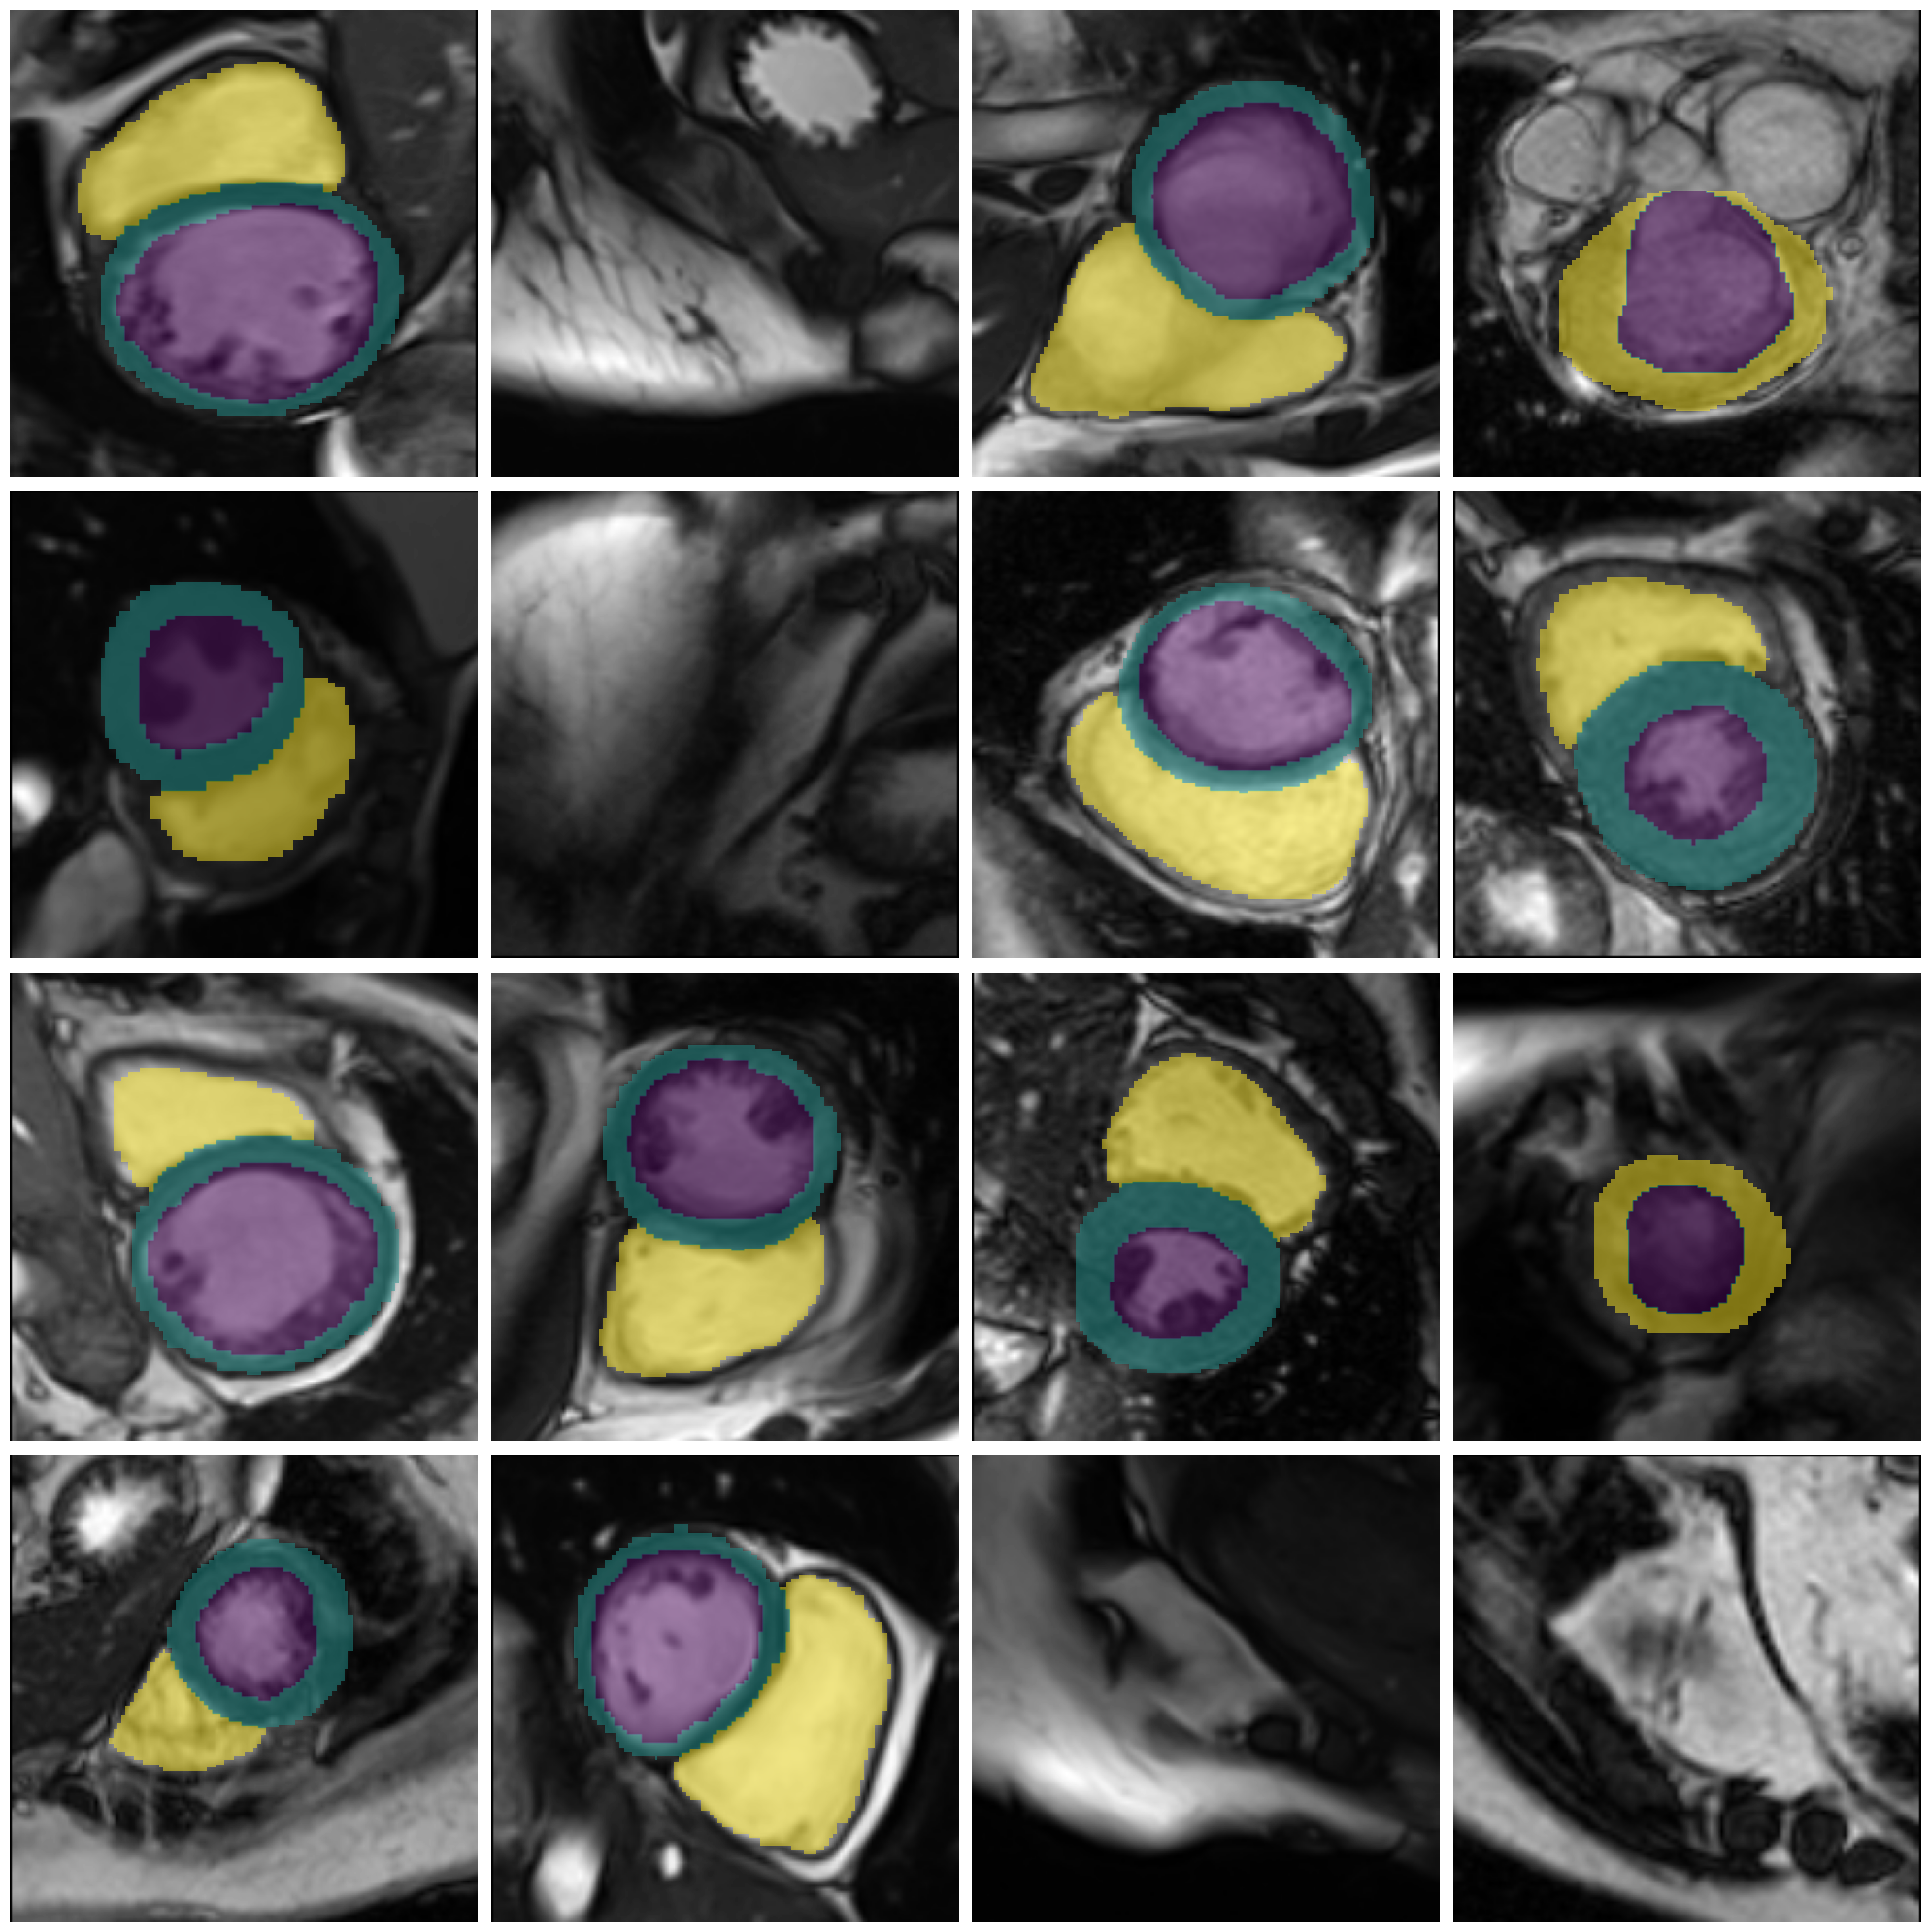

In [17]:
#################### test and visulize 25 batches to make sure dataset is fine######
batch_size=25

dataloader_train=torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, pin_memory=True)
dataloader_valid=torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, pin_memory=True)


imgs, masks = next(iter(dataloader_train))
imgs.shape, masks.shape

import matplotlib.pyplot as plt

r, c = 4, 4
fig = plt.figure(figsize=(5*r, 5*c))
for i in range(r):
    for j in range(c):
        ix = c*i + j
        ax = plt.subplot(r, c, ix + 1)
        ax.imshow(imgs[ix][0,:,:].squeeze(0),cmap="gray")
        #print(imgs[ix].squeeze(0).shape)
        mask = torch.argmax(masks[ix], axis=0).float().numpy()
        mask[mask == 0] = np.nan
        ax.imshow(mask, alpha=0.5)
        ax.axis('off')
plt.tight_layout()
plt.show()

### Step 5 Define basic 2D UNet model

In [16]:
#%% 2D model
import torch
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)
    
    # receives the output of the previous layer and the output of the stage
    #corresponding encoder #
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=4, in_ch=3):
        super().__init__()

        # list of layers in encoder-decoder with number of filters
        c = [16, 32, 64, 128]

        # first conv layer that receives the image
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # encoder layers
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # decoder layers
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # last conv layer that gives us the mask
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x
#### check model with random size
imgs=torch.rand(1,3,224,224)
model = UNet()
output = model(imgs) ### 1x3x224x224
print(output.shape)  ### prediction_mask=1x4x224x224,gt mask=1x4x224x224

torch.Size([1, 4, 224, 224])


### Training the model
for training we need loss function and optimzer to train the model
here is simple example to show the training process

In [19]:
##### define the loss function
criterion = torch.nn.BCEWithLogitsLoss()
############ define optimzer ###################
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


device = "cuda" if torch.cuda.is_available() else "cpu"
#################### start training for 2 epoch####################
epochs=2
model.train()
for epoch in range(0,epochs):
    for i,d in enumerate(dataloader):
        imgs,mask=d
        #print(imgs.shape)
        #print(mask.shape)
        ###### zero grad=====
        optimizer.zero_grad()
        imgs=imgs.to(device)
        mask=mask.to(device)
        model=model.to(device)
        ##################### feedforward model ###############
        out=model(imgs)
        loss=criterion(out,mask)
        ################### backward loss#############
        loss.backward() 
        ##################### update the gradient
        optimizer.step() 
        #print(loss.item())
    print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

Epoch 0/2 loss 0.18464
Epoch 1/2 loss 0.17736


In [25]:
##### save the trained model
path='firstmodel.pth'
torch.save(model.state_dict(),path)

In [30]:
######### test model#######################
trans = A.Compose([
    A.Resize(224, 224),
    #ToTensorV2,
])
image_folder_val='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\val\\images'
mask_folder_val='heart_dataset\\datasets\\MandM2_dataset\\2D_images_dataset\\val\\masks'
dataset_valid=Segmentation_Dataset(image_folder_val,mask_folder_val,trans=trans)
dataloader_valid=torch.utils.data.DataLoader(dataset_valid, batch_size=1, shuffle=False, pin_memory=True)
# Checking the length of the dataset
len(dataset_valid)
#################### read image and mask from val folder and convert into torch tensor
for i,d in enumerate(dataloader_valid):
    img_batch,mask_batch=d
    with torch.no_grad():
        output=model(img_batch)
        ################## convert into sigmoid, squeeze batch dimension and argmax to get prediction
        output=torch.sigmoid(output)
        output=output.squeeze(0)
        pred_mask=torch.argmax(output,axis=0)
        pred_mask=pred_mask.float().cpu().numpy()
        print(pred_mask.shape)
        print(np.unique(pred_mask))
        ############################## squeeze batch dim and argmax to get gt segmentation map
        gt=mask_batch.squeeze(0)
        gt=torch.argmax(gt,axis=0).float().cpu().numpy()
        #break
    #break

(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]
(224, 224)
[0. 1. 2. 3.]


KeyboardInterrupt: 

<function matplotlib.pyplot.imshow(X, cmap=None, norm=None, *, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None, **kwargs)>

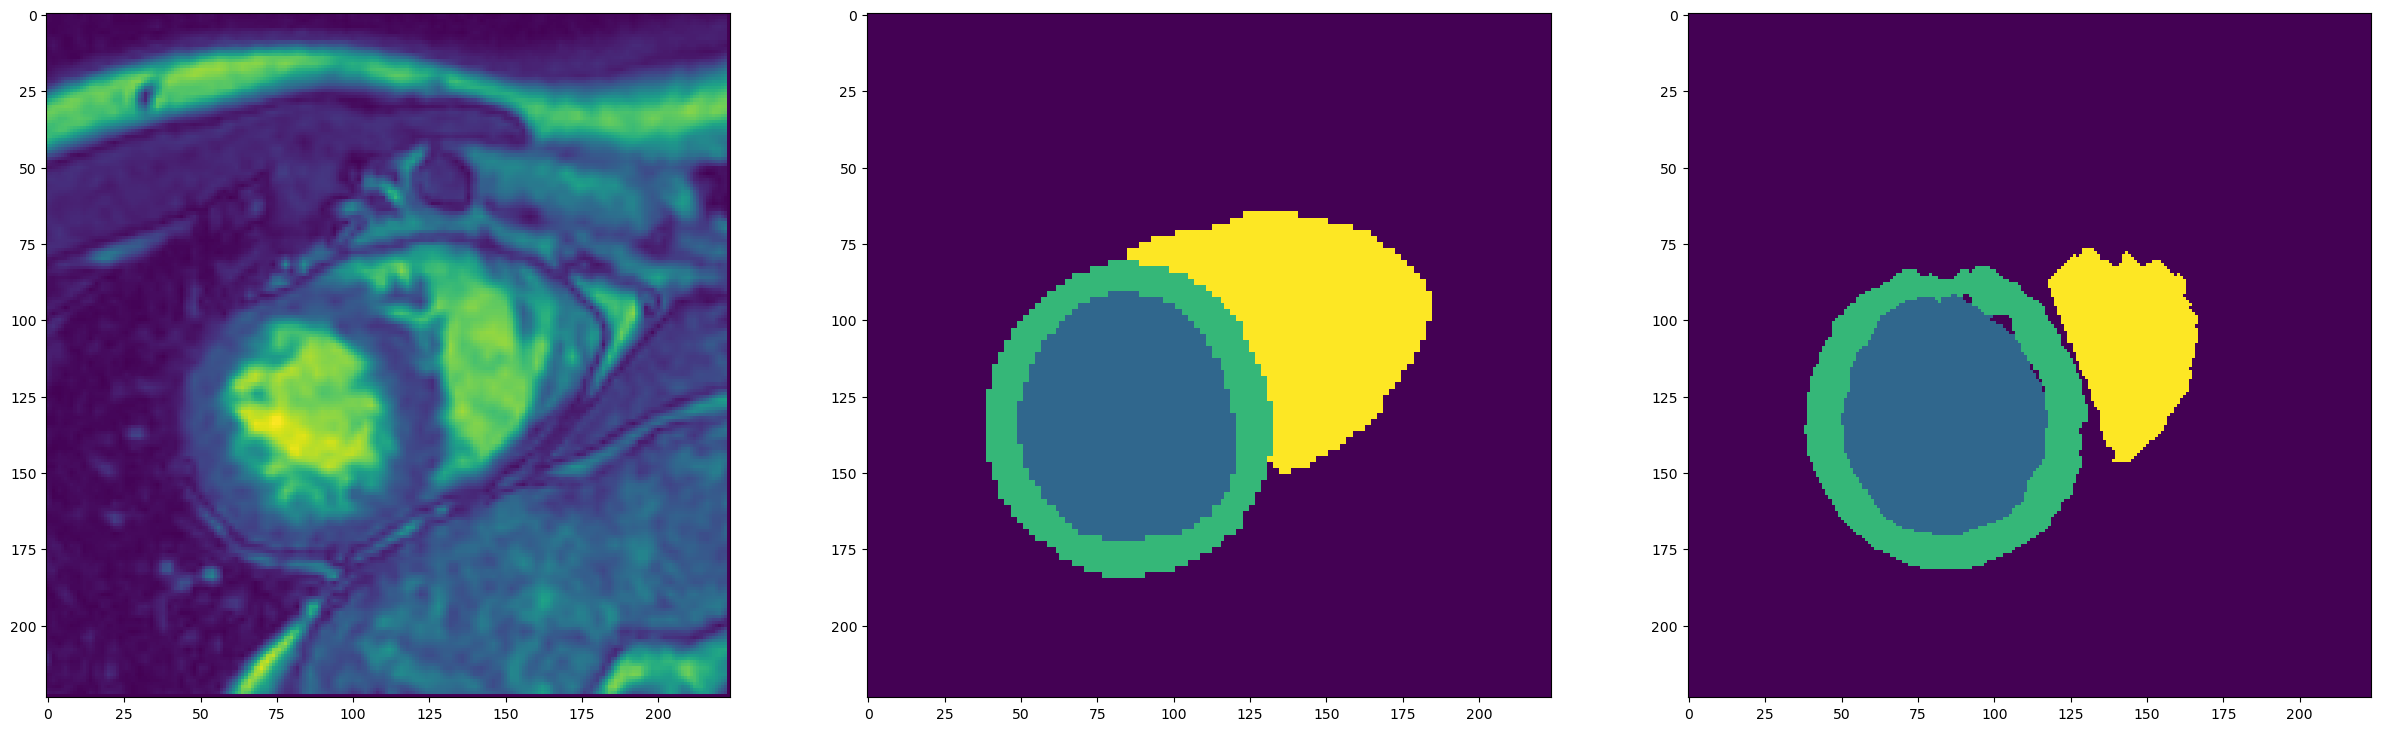

In [31]:
################## plot val image, val mask and predict mask
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(30,10))
ax1.imshow(img_batch.squeeze(0)[0,:,:].cpu().numpy())
ax2.imshow(gt)
ax3.imshow(pred_mask)
plt.imshow

In [ ]:
# The loss function is going down, so it seems to be working well.However, we need some metric 
#to evaluate how much the predicted masks are similar to the real ones. To do this we can use the 
# IoU metric and which calculates the relationship between the intersection and the union of two areas.

def iou(outputs, labels):
    # apply sigmoid and convert to binary
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # we skip the background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))  
        union = (_out | _labs).float().sum((1, 2))         
        iou = (intersection + SMOOTH) / (union + SMOOTH)  
        ious.append(iou.mean().item())
    return np.mean(ious) 

In [ ]:
############### training function with loss and iou
for epoch in range(0,epochs):
    for i,d in enumerate(dataloader):
        imgs,mask=d
        #print(imgs.shape)
        #print(mask.shape)
        ###### zero grad=====
        optimizer.zero_grad()
        imgs=imgs.to(device)
        mask=mask.to(device)
        model=model.to(device)
        ##################### feedforward model ###############
        out=model(imgs)
        loss=criterion(out,mask)
        ################### backward loss#############
        loss.backward() 
        ##################### update the gradient
        optimizer.step() 
        ################### compute ios for each batch ######
        ious = iou(out, mask)
    #############  print this after every epoch #################
    print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious.item():.5f}")

In [ ]:
################## we can train the model using training and validation and 
###################save the training and validation loss for every epoch
history={'train_loss':[],'train_ious':[] 'val_loss':[] 'val_ious':[]}
for epoch in range(0,epochs):
    train_loss=[]
    train_ious=[]
    for i,d in enumerate(dataloader_train):
        imgs,mask=d
        #print(imgs.shape)
        #print(mask.shape)
        ###### zero grad=====
        optimizer.zero_grad()
        imgs=imgs.to(device)
        mask=mask.to(device)
        model=model.to(device)
        ##################### feedforward model ###############
        out=model(imgs)
        loss=criterion(out,mask)
        ################### backward loss#############
        loss.backward() 
        ##################### update the gradient
        optimizer.step() 
        ################### compute ios for each batch ######
        ious = iou(out, mask)
        train_loss.append(loss.item())
        train_ious.append(ious.item())
    ############# mean loss and ious for each epoch
    history['train_loss'].appned(np.mean(train_loss))
    history['train_ious'].appned(np.mean(train_ious))
    
    val_loss=[]
    val_ious=[]
    model.eval()
    with torch.no_grad():
        for i,d in enumerate(dataloader_valid):
            img_b,mask_b=d
            out=model(img_b)
            loss=criterion(out,mask_b)
            ious=iou(out,mask_b)
            val_loss.append(loss.item())
            val_ious.append(ious.item())
    history['val_loss'].appned(np.mean(val_loss))
    history['val_ious'].appned(np.mean(val_ious)) 

import pandas as pd
df = pd.DataFrame(history)
df.plot(grid=True)
plt.show()